# *Insurance Premium Prediction*

![](http://pioneerinstitute.org/wp-content/uploads/healthcare_costs_scrabble.jpg)

## Problem Statement



> **QUESTION**: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, **you're tasked with creating an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits and region of residence. 
>
> Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. 
> 
>We have given a CSV file containing verified historical data, consisting of the aforementioned information and the actual medical expenses incurred by over 1300 customers. 

> Dataset source: [Kaggle](https://www.kaggle.com/noordeen/insurance-premium-prediction)
> 

### Loading Libraries

In [41]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.base import BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error, make_scorer,r2_score
import xgboost as xgb
from catboost import CatBoostRegressor

import pickle


### Load the data

In [2]:
# Let us load the dataset
df = pd.read_csv("Data\insurance.csv")
# Output key fields from the dataset
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


### Key data statistics

In [4]:
print(f"Dataset has (rows,columns) = {df.shape}")
# Print the more information about the features
df.info()

Dataset has (rows,columns) = (1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# Let us see statistical information about the Numerical features
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


The ranges of values in the numerical columns seem reasonable too (no negative ages and the min age is 18 (adult)). The "expenses" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.


* The range of expenses in the numerical column is quite variable after the 75th percentile. The ratio between the 75th and maximum is around 4 times so could be potential candidate for outliers that needs addressing.
* The range of the BMI from the 75th to the max seems reasinable.
* It seems around 50% of the sample have one child.

In [6]:
# Let us see more statiscal information of the categorical features 
df.describe(include="O")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


### Exploratory Analysis and Visualization


The following settings will improve the default style and font sizes for our charts.

In [7]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age histogram

In [22]:
def plotGraphs(df,x:str='age',title:str='Distribution of Age'):

    fig = px.histogram(df, 
                    x=x, 
                    marginal='box', 
                    nbins=47, 
                    title=title)
    fig.update_layout(bargap=0.1)
    fig.show()

plotGraphs(df,'age','Distribution of Age')
plotGraphs(df,'bmi','Distribution of BMI (Body Mass Index)')

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age band, the 18-20 age band seems to have twice as many people.
The measurements of body mass index seem to form a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) centered around the value 30, with a few outliers towards the right. For more information on BMI please see ([source](https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html)):

![](https://i.imgur.com/lh23OiY.jpg)



### Expenses

Let's visualize the distribution of "expenses" i.e. the annual medical expenses for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the expenses for smokers and non-smokers.

In [23]:
fig = px.histogram(df,
                    x='expenses',
                    marginal='box',
                    color='smoker',
                    color_discrete_sequence=['green', 'orange'],
                    title="Annual Medical Expenses")

fig.update_layout(bargap=0.1)
fig.show()    



We observe the following trends from the above graph:

* Majority of customer have annual medical expenses below 10k. We see a sharp decline in the number of customers with over 10K.
* We see a significant increase in the medical expense for smokers vs non- smokers.


### Expenses by gender

In [26]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="sex",
                    color_discrete_sequence=["blue", "purple"],
                    title="Annual Medical Expenses by Sex")

fig.update_layout(bargap=0.1)
fig.show()                    

Summary:

* While the median average expense for males vs females is about the same, there are more extremes expenses with males suggesting a higher degree of variability.

### DIstribution of expenses by Region

In [27]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="region",
                    color_discrete_sequence=["grey", "orange", "green","violet"],
                    title="Annual Medical Expenses by Region")

fig.update_layout(bargap=0.1)
fig.show()                    

Summary:

* We see a higher degree of variation in expenses for the south east

### Smoker by gender visualization

In [32]:
px.histogram(df, x="smoker", color="sex", title="Smoker by gender counts")

Summary:
* Around 20% of the customers have been reported to be smokers.
* More smokers amongst the males than females.

In [37]:
px.histogram(df, x="region", color="smoker", title="Region").show()
px.histogram(df, x="smoker", color="children", title="Smoker Vs Children").show()

Having looked at individual columns, we can now visualize the relationship between "expenses" (the value we wish to predict) and other columns.

### Age and Charges

Let's visualize the relationship between "age" and "expenses" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [40]:
fig = px.scatter(df,
                x="age",
                y="expenses",
                color="smoker",
                opacity=0.8,
                hover_data=["sex"],
                width=800,
                height=500,
                title="Age vs Expenses")

fig.update_traces(marker_size=5)
fig.show()                

Summary:

* The general trend seems to be that medical expenses increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical expenses.


* Generally we observe three clusters:

     1. The first seem to be "healthy non-smokers" with  lower medical expenses.
     
     2. The second cluster contains of a mix of smokers and non-smokers. Could be a mix of "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers - potentially smokers with medical issues that are possibly worsened by smokers.
     


### BMI and Expenses

In [41]:
fig = px.scatter(df,
                x="bmi",
                y="expenses",
                color="smoker",
                hover_data=['sex'],
                opacity=0.8,
                width=800,
                height=500,
                title="BMI Vs Expenses")

fig.update_traces(marker_size=5)
fig.show()                

It appears, for non-smokers, an increase in BMI doesn’t exhibit a linear increase. However, medical expenses are significantly higher for smokers with a BMI greater than 30.


In [42]:
fig = px.scatter(df,
                x="bmi",
                y="expenses",
                color="smoker",
                hover_data=['region'],
                opacity=0.9,
                width=800,
                height=500,
                title= "BMI Vs Expenses")

fig.update_traces(marker_size=5)
fig.show()               

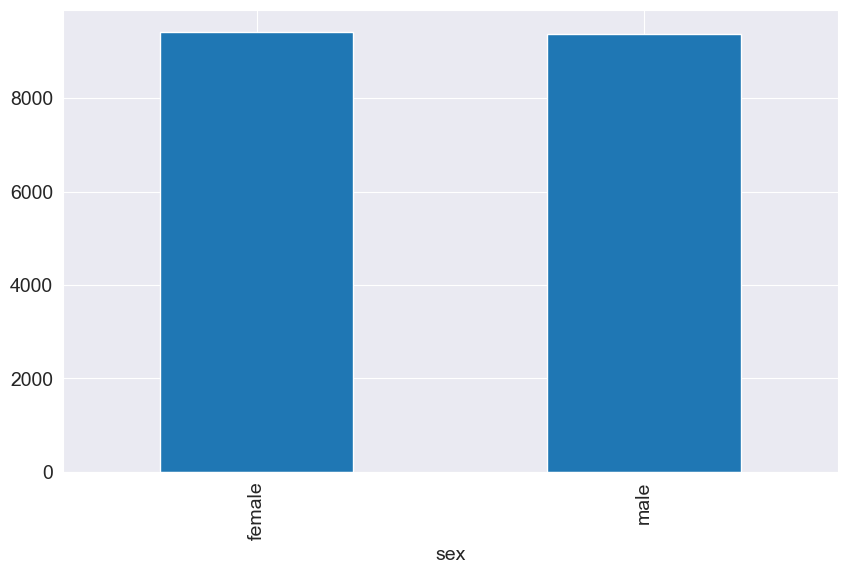

In [45]:
df.groupby("sex")['expenses'].median().plot.bar()
plt.show()

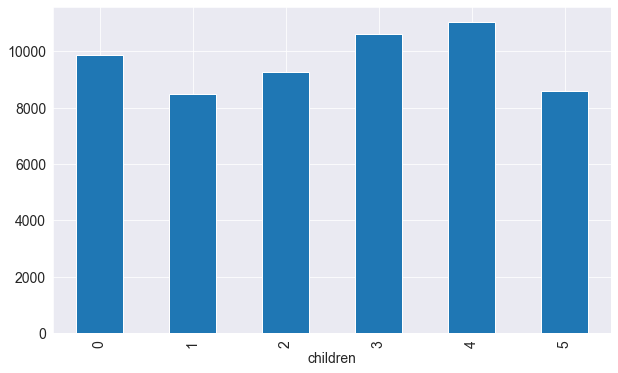

In [20]:
df.groupby("children")['expenses'].median().plot.bar()
plt.show()

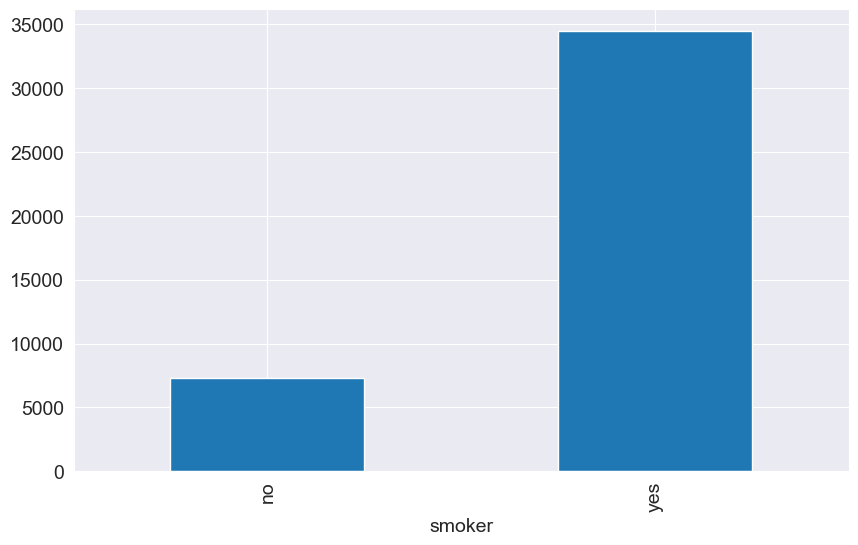

In [44]:
df.groupby("smoker")['expenses'].median().plot.bar()
plt.show()

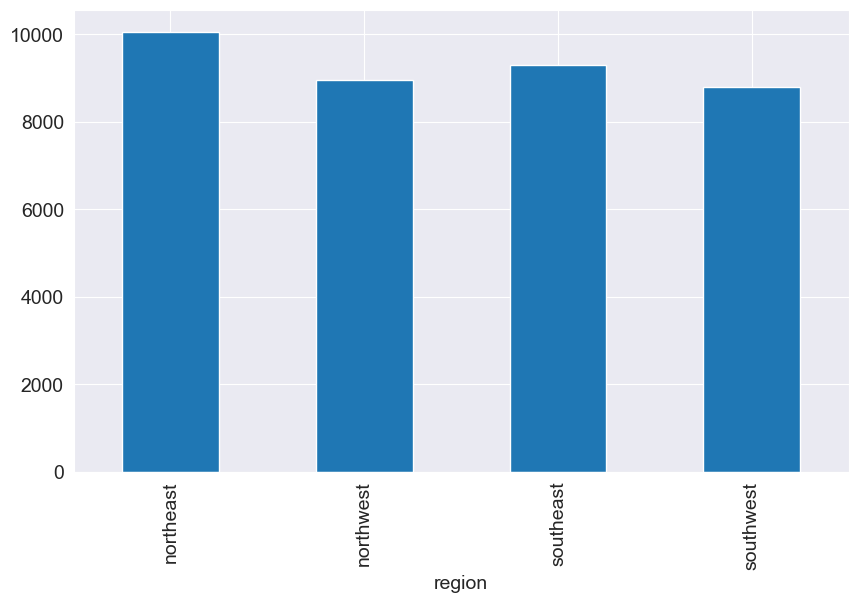

In [43]:
df.groupby("region")['expenses'].median().plot.bar()
plt.show()

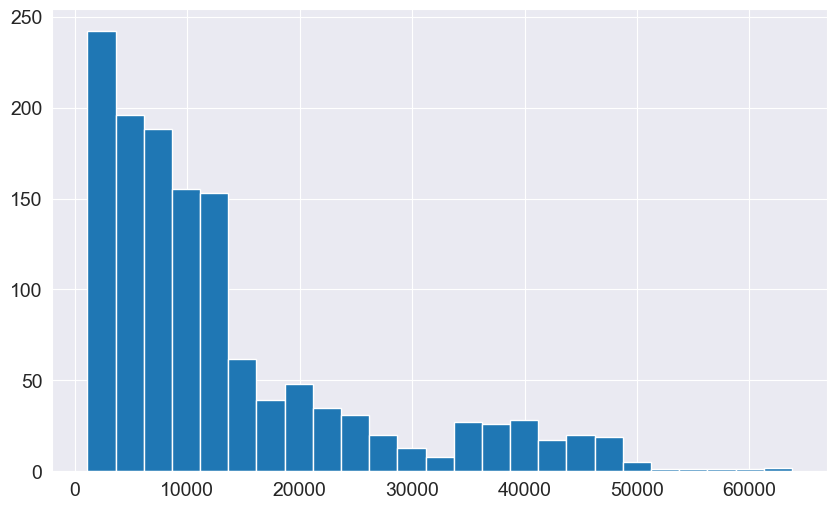

In [48]:
df['expenses'].hist(bins=25)
plt.show()

In [49]:
fig = px.histogram(data_frame=df, x='bmi', y='expenses', width=800, height=500, title='Expenses by BMI')
fig.show()

In [50]:
fig = px.histogram(df, x="bmi", y="expenses", color="sex", marginal="rug", hover_data=df.columns)
fig.show()

In [51]:
fig = px.scatter(df, x="bmi", y="expenses", color='sex', facet_col="children")
fig.update_xaxes(matches=None)
fig.show()

In [52]:
fig = px.pie(data_frame=df, names='sex', values='expenses', width=800, height=500, title='Expenses by Gender')
fig.show()

In [55]:
fig = px.scatter(df, x="bmi", y="expenses", color="smoker", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

*  We see that the health expenses for smokers has a much wider range compare to non-smokers. 

In [56]:
fig = px.scatter(df, x="bmi", y="expenses", color="region", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

*  We see, in the south east, we more variable BMIs.

### Correlation

In [3]:
df[['age','bmi','children','expenses']].corr()

,age,bmi,children,expenses
age,1.000000,0.109341,0.042469,0.299008
bmi,0.109341,1.000000,0.012645,0.198576
children,0.042469,0.012645,1.000000,0.067998
expenses,0.299008,0.198576,0.067998,1.000000


Text(0.5, 1.0, 'Correlation Matrix')

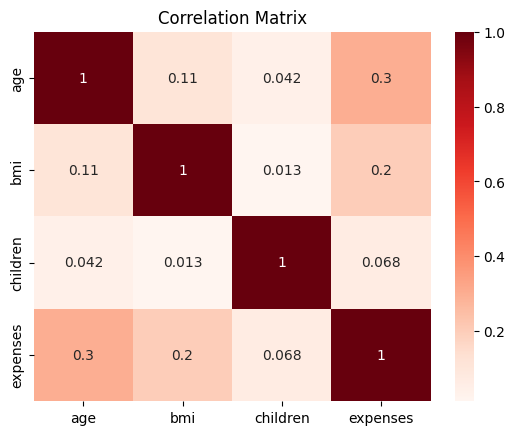

In [4]:
sns.heatmap(df[['age','bmi','children','expenses']].corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix')

**Correlation vs causation fallacy:** Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features $X$ and $Y$ can be correlated if $X$ causes $Y$ or if $Y$ causes $X$, or if both are caused independently by some other factor $Z$, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that $X$ are $Y$ simply appear to be correlated because the sample is too small. 

In [5]:
print(f"Correlation of expense vs age {np.round(df.expenses.corr(df.age),3)}")
print(f"Correlation of expense vs BMI {np.round(df.expenses.corr(df.bmi),3)}")

Correlation of expense vs age 0.299
Correlation of expense vs BMI 0.199


To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [6]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = df.smoker.map(smoker_values)
np.round(df.expenses.corr(smoker_numeric),3)

0.787

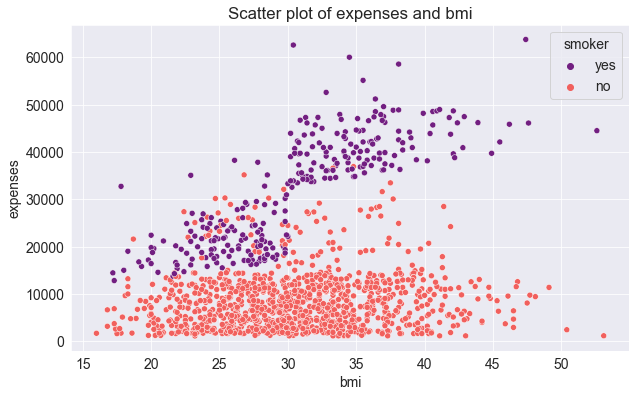

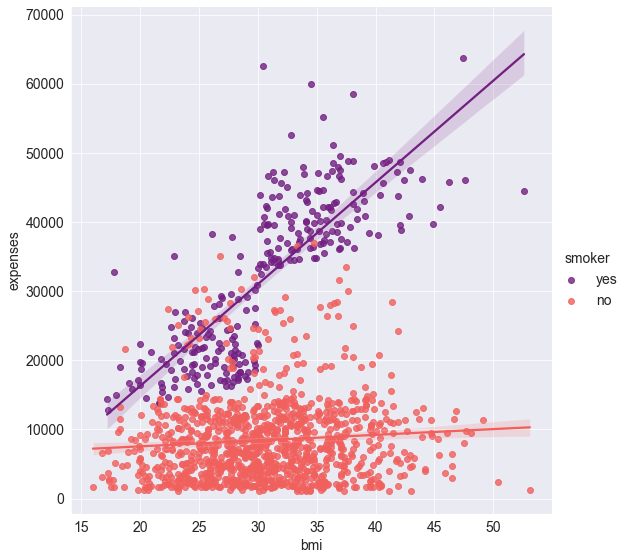

In [42]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='expenses',data=df,palette='magma',hue='smoker')
ax.set_title('Scatter plot of expenses and bmi')

sns.lmplot(x="bmi", y="expenses", hue="smoker", data=df, palette = 'magma', size = 8)


In [114]:
#f = plt.figure(figsize=(12, 4))

# Create a figure with a 1x2 grid
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Create the first histogram
fig1 = px.histogram(df, x="expenses", nbins=50, color_discrete_sequence=['red'], title="Distribution of insurance expenses")

# Create the second histogram
fig2 = px.histogram(np.log1p(df['expenses']), x="expenses", nbins=40, color_discrete_sequence=['red'], title="Distribution of insurance expenses on log scale")

# Display the two histograms
fig1.show()
fig2.show()

If we look at the left plot the expenses varies from 1120 to 63500, the plot is right skewed. In the bottom plot we will apply natural log, then plot approximately tends to normal. for further analysis we will apply log + 1 (as log 0 is undefined) on target variable charges.

### Split the data set for ML training and testing

In [ ]:
from sklearn.datasets import make_regression
# Generate a random regression dataset
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the PyTorchRegressor
input_size = X_train.shape[1]


### Define a NN based model using Pytorch

In [3]:
def rmse_loss(output, target):
    mse = F.mse_loss(output, target)
    rmse = mse.sqrt()
    return rmse

class PyTorchRegressor(nn.Module):
    def __init__(self, input_size,hidden_sizes=(32, 16), epochs = 20, batch_size=32, learning_rate=0.001, dropout_rate=0.2):
        super(PyTorchRegressor, self).__init__()
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.hidden_sizes = hidden_sizes
        self.dropout_rate = dropout_rate
        
        # Define the layers
        layers = []
        input_dim = self.input_size
        print("hidden_sizes=",self.hidden_sizes)
        for hidden_size in self.hidden_sizes:
            print("hidden_size",hidden_size)
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_size
        layers.append(nn.Linear(input_dim, 1))
        print("layers=",layers)
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, y):
        # Convert data to PyTorch tensors
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        
        # Define the loss function and optimizer
        #criterion = nn.MSELoss()
        criterion = rmse_loss
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Train the model 
        #Loop through the epochs (An epoch refers to one complete pass through the entire training dataset)
        for epoch in range(self.epochs):
           #Loop through the batches 
            for i in range(0, X.shape[0], self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]

                #print(batch_X.shape," ",batch_y.shape)
                # Reset the gradients of the model parameters to zero before backpropagation
                optimizer.zero_grad()
                # Pass the input batch through the model to get the predicted outputs
                outputs = self(batch_X)
                # Calculate the loss between the predicted outputs and the target values using the specified loss function
                loss = criterion(outputs, batch_y)
                # Compute the gradients of the loss with respect to the model parameters using backpropagation
                loss.backward()
                # Update the model parameters based on the computed gradients and the optimization algorithm
                optimizer.step()
            # Print the loss every 10 epochs 
            if (epoch + 1) % 10 == 0:
                pass
                #print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {loss.item():.4f}')
        
    def predict(self, X):
        # Convert data to PyTorch tensor
        X = torch.tensor(X, dtype=torch.float32)
        
        # Make predictions
        with torch.no_grad():
            outputs = self(X)
            predictions = outputs.squeeze(1).numpy()
        
        return predictions
    
    def set_params(self, **params):
        for param, value in params.items():
            if hasattr(self, param):
                setattr(self, param, value)
        return self


### Run performance across a number of ML algorithms

In [4]:
# Get RMSE 
rmse_scorer = make_scorer(mean_squared_error, squared=False)

X = df.drop(['expenses'], axis=1)

# Assuming your data is in a pandas DataFrame called 'df'
y = df['expenses']
#check missing values in any rows
rows_with_missing = df.isna().any(axis=1)
print(f"rows_with_missing = {np.sum(df.isna().any(axis=1))}")
# Splitting the dataset for training and testing the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Let us check shape of the training & test set
print(X_train.shape, y_train.shape)

# Assuming X_train is a pandas DataFrame
column_names = X_train.columns

# Create a mapping between column names and indices
column_indices = {name: i for i, name in enumerate(column_names)}

# Define the numerical and categorical feature names
numerical_feature_names = ['age', 'bmi', 'children']
categorical_feature_names = ['sex', 'smoker','region']

# Convert feature names to indices
numeric_features = [column_indices[name] for name in numerical_feature_names]
categorical_features = [column_indices[name] for name in categorical_feature_names]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Impute missing values with median
    ('scaler', StandardScaler()) # Standardize features by removing the mean and scaling to unit variance
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Impute missing values with 'missing' category
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])


# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the models to test
models = [
    ('Linear Regression', LinearRegression()),
    ('ElasticNet',ElasticNet()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('CatBoostRegressor', CatBoostRegressor()),
    ('XGBRegressor',  xgb.XGBRegressor()),
    # define call to the PyTorchRegressor class later as we need to
    # input the transformed input variables
    ('PyTorchRegressor', None),
    
]


# Create an empty list to store the results
model_results = []

# Perform Bayesian optimization for each model
for name, model in models:

    print(f"Running model: {name}")
    # Define the hyperparameter search space
    if name == 'Linear Regression':
        param_grid = {
            'model__fit_intercept': [True, False],
        }
    elif name == 'ElasticNet':
        param_grid = {
        'model__alpha': (0.0001, 0.001, 0.01, 0.1, 1.0, 10.0),
        'model__l1_ratio': (0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
        }
    elif name == 'Decision Tree':
        param_grid = {
            'model__max_depth': (2, 10),
            'model__min_samples_split': (2, 10),
        }
    elif name == 'Random Forest':
        param_grid = {
            'model__n_estimators': (100, 500),
            'model__max_depth': (2, 10),
        }
    elif name == 'Gradient Boosting':
        param_grid = {
            'model__n_estimators': (100, 500),
            'model__learning_rate': (0.01, 0.3),
        }
    elif name == 'XGBRegressor':
        param_grid = {
            'model__max_depth': [5, 7, 10],
            'model__learning_rate': [0.05, 0.1],
            'model__n_estimators': [100, 200],
        }
    elif name == 'CatBoostRegressor':
        param_grid = {
        'model__n_estimators': [100, 200, 500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [4, 6, 10]
    }

    elif name == 'PyTorchRegressor':
        # Define the hyperparameter search space for the PyTorch model
        param_grid = {
            #'model__hidden_sizes':  [(32,),(32,16)],
            'model__dropout_rate': [0.2, 0.4],
            'model__learning_rate': [0.001, 0.01],
            #'model__batch_size': [32, 128],
            #'model__epochs': [50, 200]
        }

    print(X_train.shape,y_train.values.shape)
    

    if name == 'PyTorchRegressor':

        X_train_NN = preprocessor.fit_transform(X_train)
        X_test_NN = preprocessor.fit_transform(X_test)
        print(X_train.shape)

        # Create the pipeline with Bayesian optimization. For PyTorchRegressor, apply the transformation first
        # and dont point in pipeline.
        pipeline = Pipeline(steps=[
            #('preprocessor', preprocessor),
            ('model', PyTorchRegressor(input_size = X_train_NN.shape[1]))
        ])
        
        search = BayesSearchCV(pipeline
        , search_spaces=param_grid
        , cv=5
        , scoring=rmse_scorer
        , n_iter=20
        , random_state=42
        , n_jobs=1
        , verbose=5)


        search.fit(X_train_NN, y_train.ravel())
        y_pred = search.predict(X_test_NN)

        # Evaluate the best model on the test set
        rmse_score = search.score(X_test_NN, y_test.values)


    else:
        # Create the pipeline with Bayesian optimization
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        search = BayesSearchCV(pipeline
        , search_spaces=param_grid
        , cv=5
        , scoring=rmse_scorer
        , n_iter=20
        , random_state=42
        , n_jobs=1
        , verbose=5)

    
        search.fit(X_train, y_train.ravel())
        y_pred = search.predict(X_test)
 
        rmse_score = search.score(X_test, y_test.values)

    # Prediction from the model
    r2_score_value = r2_score(y_test.values,y_pred.ravel())

    print(f"{name} Test RMSE: {rmse_score:.2f}")
    print(f"{name} R^2 Accuracy: {r2_score_value:.2f}")

    # Print the best hyperparameters
    print(f"{name} Best Hyperparameters: {search.best_params_}")


    model_results.append({
        'Model_Name': name,
        'RMSE': rmse_score,  
        'R2': r2_score_value,
        'Best_params': search.best_params_
    })

# Create the DataFrame from the results list
results_df = pd.DataFrame(model_results)
# Sort the final output table by RMSE and then R2
results_df.sort_values(by=['RMSE','R2'], ascending=[True,False],inplace=True)
results_df

rows_with_missing = 0
(1070, 6) (1070,)
Running model: Linear Regression
(1070, 6) (1070,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ......model__fit_intercept=True;, score=6334.419 total time=   0.0s
[CV 2/5] END ......model__fit_intercept=True;, score=5663.466 total time=   0.0s
[CV 3/5] END ......model__fit_intercept=True;, score=5993.167 total time=   0.0s
[CV 4/5] END ......model__fit_intercept=True;, score=6825.320 total time=   0.0s
[CV 5/5] END ......model__fit_intercept=True;, score=5917.819 total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .....model__fit_intercept=False;, score=6334.419 total time=   0.0s
[CV 2/5] END .....model__fit_intercept=False;, score=5663.466 total time=   0.0s
[CV 3/5] END .....model__fit_intercept=False;, score=5993.167 total time=   0.0s
[CV 4/5] END .....model__fit_intercept=False;, score=6811.332 total time=   0.0s
[CV 5/5] END .....model__fit_intercept=False;, score=5917.819 

In [10]:
# Sort the final output table by RMSE and then R2
results_df.sort_values(by=['RMSE','R2'], ascending=[True,False],inplace=True)
results_df


,Model_Name,RMSE,R2,Best_params
6,XGBRegressor,4732.444045,0.855741,"{'model__learning_rate': 0.1, 'model__max_dept..."
3,Random Forest,4945.324197,0.842471,"{'model__max_depth': 2, 'model__n_estimators':..."
4,Gradient Boosting,5230.090930,0.823806,"{'model__learning_rate': 0.3, 'model__n_estima..."
0,Linear Regression,5797.925966,0.783470,{'model__fit_intercept': True}
2,Decision Tree,6346.908505,0.740524,"{'model__max_depth': 10, 'model__min_samples_s..."
5,CatBoostRegressor,7103.560276,0.674970,"{'model__learning_rate': 0.01, 'model__max_dep..."
1,ElasticNet,12065.390966,0.062320,"{'model__alpha': 10.0, 'model__l1_ratio': 0.0}"
7,PyTorchRegressor,16091.177578,-0.664057,"{'model__dropout_rate': 0.2, 'model__learning_..."


* We see that XGBRegressor has the best combined (RMSE & R-squared), followed by Random forest and Gradient Boosting. 

In [40]:
select_best_model = results_df[results_df.get("Model_Name")=="XGBRegressor"]

print("final_n_estimators = ", select_best_model['Best_params'].apply(lambda x: x['model__n_estimators']).values[0])
print("final_max_depth = ", select_best_model['Best_params'].apply(lambda x: x['model__max_depth']).values[0])
print("final_learning_rate = ", select_best_model['Best_params'].apply(lambda x: x['model__learning_rate']).values[0])

# Create the final XGBoost model with the best hyperparameters
final_model = xgb.XGBRegressor(
    n_estimators = select_best_model['Best_params'].apply(lambda x: x['model__n_estimators']).values[0],
    max_depth = select_best_model['Best_params'].apply(lambda x: x['model__max_depth']).values[0],
    learning_rate = select_best_model['Best_params'].apply(lambda x: x['model__learning_rate']).values[0],
)
# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', final_model)
])
# Fit the final model on the training data
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

r2_score_final_value = r2_score(y_test.values,y_pred.ravel())
print("r2_score_final_value = ",r2_score_final_value)

final_n_estimators =  177
final_max_depth =  10
final_learning_rate =  0.1
r2_score_final_value =  0.8557410028595424


### Export the final pipeline/model and save as a joblib file

In [83]:
joblib.dump(pipeline, 'Model_file\\final_model.joblib')
loaded_pipeline = joblib.load('Model_file\\final_model.joblib')
y_pred = loaded_pipeline.predict(X_test)
r2_score_final_value_test = r2_score(y_test.values,y_pred.ravel())
print("r2_score_final_test_value = ",r2_score_final_value_test)

r2_score_final_test_value =  0.8557410028595424


In [59]:
loaded_pipeline.predict(X_test.head(1))[0]


9602.059

In [75]:

#loaded_pipeline.predict(X_test.head(1).to_dict(orient='records')[0])


#pd.DataFrame(

test = loaded_pipeline.predict(pd.DataFrame([X_test.head(1).to_dict(orient='records')[0]]))
#[X_test.head(1).to_dict(orient='records')[0]]

loaded_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0, 2, 3]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [1, 4, 5])])),
                ('model',
                 XGBRegressor(ba...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=177, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [79]:
pred_data = pd.DataFrame({'age': 45,
'sex': 'female',
'bmi': 25.2,
'children': 2,
'smoker': 'no',
'region': 'northeast'},index=[0])

loaded_pipeline.predict(pred_data)[0]

9602.059